In [1]:
import torch
import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float64)

In [2]:
def olivers_fn(X: torch.Tensor, w: float = 1, gamma: float = 0.01, noise: float = 0):
    y = torch.prod(torch.sin(w * (X + 1)) * (1 - torch.tanh(gamma * ((X + 1) ** 2))), dim=-1, keepdim=True)
    if noise:
        y += torch.normal(0, noise, size=y.shape)
    return y

def det_fn(X: torch.Tensor, Y: torch.Tensor):
    return (2 * torch.exp(-torch.mean(X ** 2 / 3, dim=-1, keepdim=True)) * Y) + (0.2 * X.mean(dim=-1, keepdim=True))

In [3]:
N = 80
NOISE = 0.1
bounds = torch.tensor([[-8], [8]])
x = torch.linspace(bounds[0][0], bounds[1][0], 10000).unsqueeze(-1)
x_sample = torch.normal(mean=0, std=5, size=(N, 1))
x_sample = torch.clamp(x_sample, bounds[0].item(), bounds[1].item())

y_true_m = olivers_fn(x, noise=0)
y_true = det_fn(x, y_true_m)
y_sample_m = olivers_fn(x_sample, noise=NOISE)
y_sample = det_fn(x_sample, y_sample_m)

x_sample = x_sample.repeat(1,2)
x = x.repeat(1,2)
bounds = bounds.repeat(1,2)


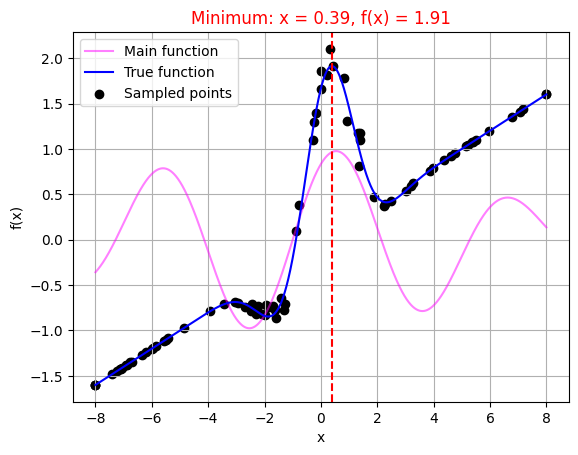

In [4]:
plt.plot(x[:,0],y_true_m, color = 'magenta', label = 'Main function', alpha = 0.5)
#plt.plot(x,det_fn(x), color = 'purple', label = 'Deterministic function', alpha =0.5)
plt.plot(x[:,0],y_true, color = 'blue', label = 'True function')
plt.scatter(x_sample[:,0],y_sample, color = 'black', label = 'Sampled points')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true.max())
plt.axvline(x[:,0][np.argmax(y_true)],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [5]:
class GP_RBF(botorch.models.SingleTaskGP):
    def __init__(self,bounds,device = 'cpu', deterministic_loss = None):
        self.device = device
        self.bounds = bounds.to(device)
        self.mean_y = 0
        self.std_y = 0
        self.apply_det = False
    def fit(self,X:torch.tensor,Y:torch.tensor,use_scipy = True,options:dict = None,**kwargs):
        X = X.to(self.device)
        Y = Y.to(self.device)
        X = self.normalization(X, self.bounds)
        super().__init__(X,Y,outcome_transform = botorch.models.transforms.Standardize(m=1), **kwargs)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        botorch.fit.fit_gpytorch_mll(mll)
        return self
    @staticmethod
    def normalization(X:torch.tensor, bounds):
        #return X
        return (X - bounds[0,:]) / (bounds[1,:] - bounds[0,:])
    def predict(self,x,return_std = False,**kwargs):
        #self.eval()
        observed_pred = self.posterior(x,**kwargs)
        y_pred = observed_pred.loc.cpu()
        std_pred = observed_pred.covariance_matrix.diag().sqrt().cpu()
        if return_std: return y_pred,std_pred
        else: return y_pred
    def posterior(self, X, **kwargs):
        """
        Override posterior to apply weight loss transformation for scalar outputs
        """
        posterior = super().posterior(self.normalization(X, self.bounds), **kwargs)
        mean = posterior.loc*(-1)

        if self.apply_det: mean = det_fn(X.reshape(-1,self.bounds.size(-1)),mean.reshape(-1,1)).reshape(mean.shape)
        posterior.loc = mean*(-1)
        return posterior
    def deterministic_loss(self,X,Y):
        return det_fn(X,Y)
    
class SingleTaskIBNN(GP_RBF):
    def __init__(self, bounds, device = torch.device('cpu'),
                 var_w = None,var_b = None,depth = 3, deterministic_loss = None
                ):
        super().__init__(bounds,device)
        self.model_args = {'var_w':var_w,'var_b':var_b, 'depth':depth}
        self._kernel = None
    def fit(self,X,Y,use_scipy = True,options:dict = None,**kwargs):
        if self._kernel is None: kernel = botorch.models.kernels.InfiniteWidthBNNKernel(depth=self.model_args['depth'])
        else: kernel = self._kernel
        super().fit(X,Y,covar_module=kernel,use_scipy = use_scipy,options= options,**kwargs)
        self._kernel = kernel
        return self

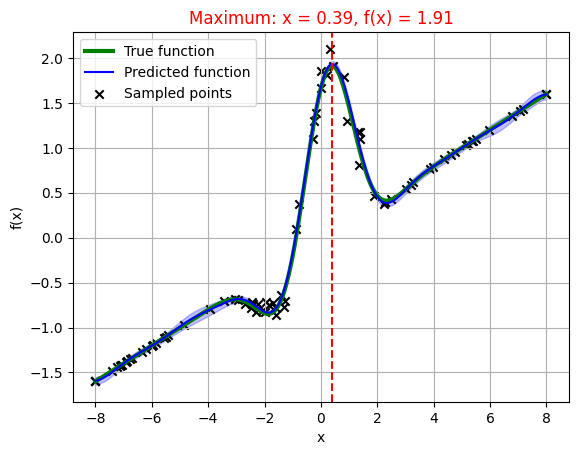

In [6]:
gpr = GP_RBF(bounds)
gpr.fit(x_sample,y_sample)
with torch.no_grad():   
    y_pred, std = gpr.predict(x,return_std = True)
plt.plot(x[:,0],y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x[:,0],y_pred.detach().cpu().numpy(), color = 'blue', label = 'Predicted function')
plt.fill_between(x[:,0].flatten(),y_pred.flatten()-std,y_pred.flatten()+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample[:,0],y_sample, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [7]:
gpr = SingleTaskIBNN(bounds)
gpr.fit(x_sample,y_sample)

/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py

SingleTaskIBNN(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): InfiniteWidthBNNKernel(
    (raw_weight_var_constraint): Positive()
    (raw_bias_var_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (_kernel): InfiniteWidthBNNKernel(
    (raw_weight_var_constraint): Positive()
    (raw_bias_var_constraint): Positive()
  )
)

In [8]:
with torch.no_grad():   
    y_pred, std = gpr.predict(x,return_std = True)

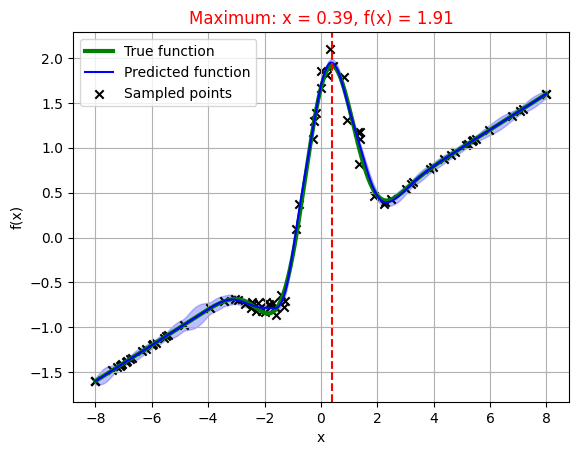

In [9]:
plt.plot(x[:,0],y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x[:,0],y_pred.detach().cpu().numpy(), color = 'blue', label = 'Predicted function')
plt.fill_between(x[:,0].flatten(),y_pred.flatten()-std,y_pred.flatten()+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample[:,0],y_sample, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [10]:
gpr = GP_RBF(bounds)
gpr.apply_det = True
gpr.fit(x_sample,(-1)*y_sample_m)

GP_RBF(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (lengthscale_prior): LogNormalPrior()
    (raw_lengthscale_constraint): GreaterThan(2.500E-02)
  )
  (outcome_transform): Standardize()
)

In [11]:
with torch.no_grad():   
    y_pred, std = gpr.predict(x,return_std = True)
    y_pred *= -1

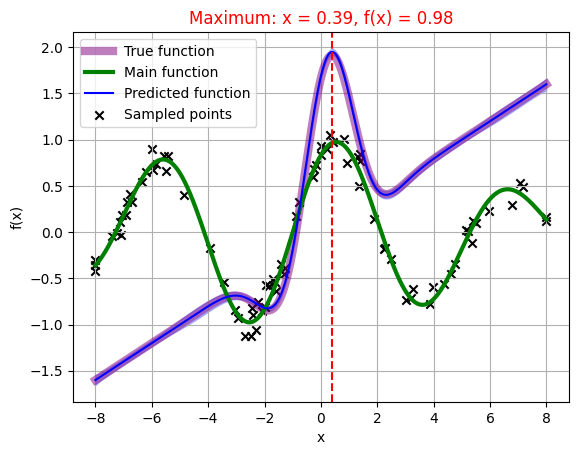

In [12]:
plt.plot(x[:,0],y_true, color = 'purple', label = 'True function',linewidth = 6, alpha = 0.5)
plt.plot(x[:,0],y_true_m, color = 'green', label = 'Main function',linewidth = 3)
plt.plot(x[:,0],y_pred.detach().cpu().numpy(), color = 'blue', label = 'Predicted function')
plt.fill_between(x[:,0].flatten(),y_pred.flatten()-std,y_pred.flatten()+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample[:,0],y_sample_m, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true_m.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

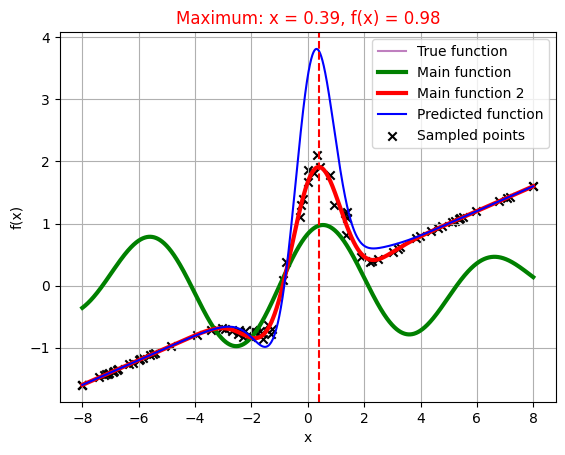

In [13]:
plt.plot(x[:,0],y_true, color = 'purple', label = 'True function',linewidth = 1.5, alpha = 0.5)
plt.plot(x[:,0],y_true_m, color = 'green', label = 'Main function',linewidth = 3)
plt.plot(x[:,0],det_fn(x,y_true_m), color = 'red', label = 'Main function 2',linewidth = 3)
plt.plot(x[:,0],det_fn(x,y_pred.view(-1,1)), color = 'blue', label = 'Predicted function')
#plt.fill_between(x[:,0].flatten(),det_fn(x,y_pred.view(-1,1)).flatten()-std,det_fn(x,y_pred.view(-1,1)).flatten()+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample[:,0],y_sample, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true_m.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()